In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.extend(['..'])

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import make_moons

from torch.nn.functional import softmax as torch_softmax

from models import DNN
from utils import plot_toy_regions

In [4]:
dev = torch.device('cuda:1')

## Toy example: 2D Classification 

In [5]:
X, y = make_moons(n_samples=200, noise=0.1)

X_train = torch.as_tensor(X, dtype=torch.float32)
y_train = torch.as_tensor(y, dtype=torch.float32).view(-1, 1)

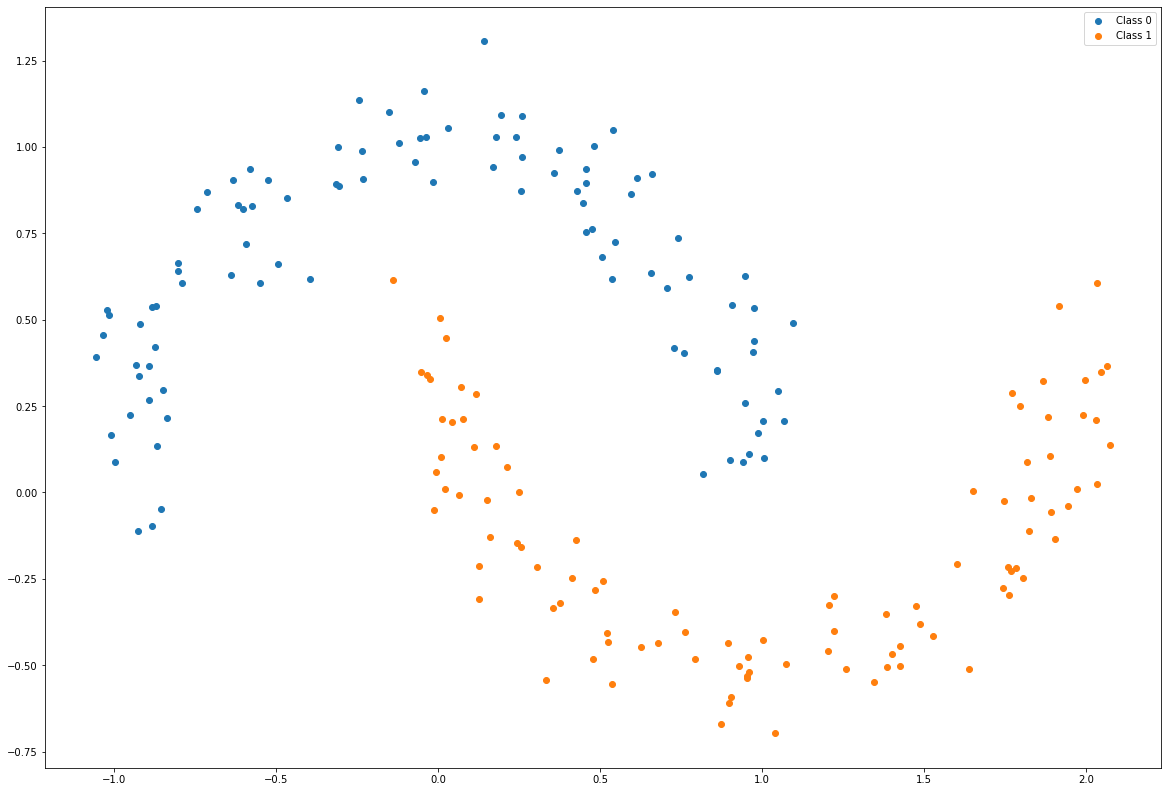

In [6]:
fig, ax = plt.subplots(figsize=(20, 14))

ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], label='Class 1')
ax.legend()

plt.show();

### DNN overfitting:

In [7]:
epochs = 5000

In [8]:
# Define forward pass
dnn = DNN(d_in=2, d_out=1, hidden_size=[10, 10])

# Initialized set of parameters
Wb = dnn.gen_params()

# Init optimizer and loss function
optimizer = torch.optim.SGD([Wb], lr=1e-3)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [9]:
_loss = []
for e in range(epochs):
    
    z = dnn(X_train, Wb)
    
    curr_loss = loss(z, y_train)
    
    curr_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    _loss.append(curr_loss.item())

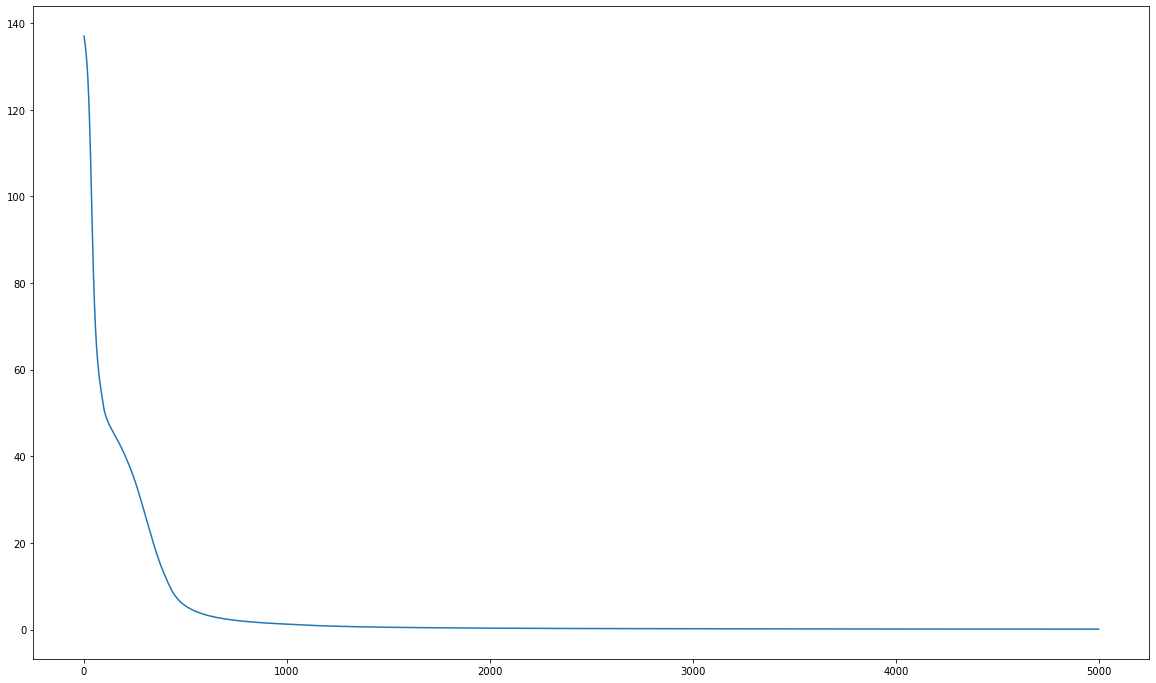

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(_loss)

plt.show()

In [11]:
def predict(X, Wb):
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32, device=Wb.device)
    z = dnn(X, Wb)
    return torch.sigmoid(z).cpu().detach().numpy()

We have perfect accuracy:

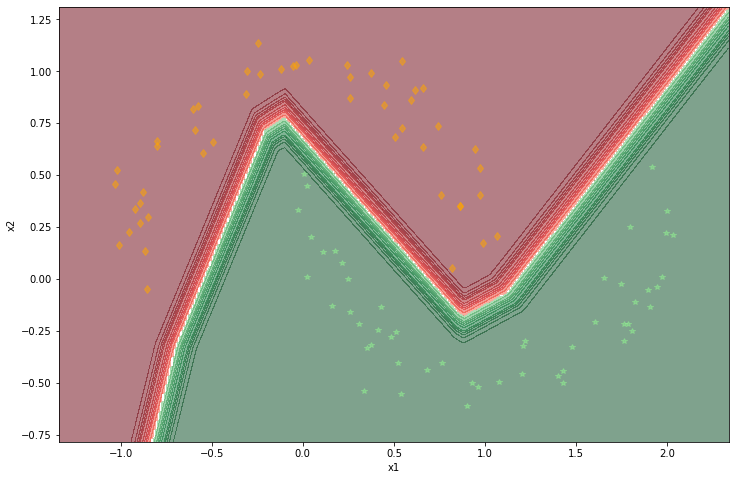

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict(x, Wb),
                      ax=ax)
plt.show();

But we make confident predictions on regions of input space where we have seen no data.

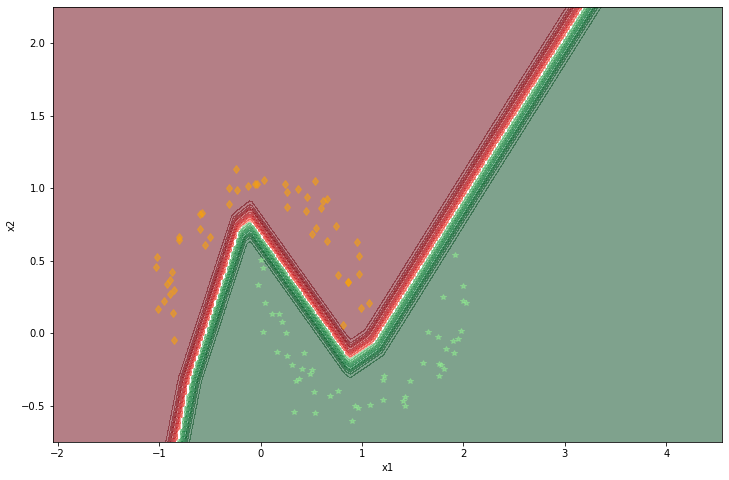

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict(x, Wb),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

### Model Average

#### One solution is to average over models that explain well the data:

In [14]:
n_models = 10

# Initialized set of parameters
Wbs = [dnn.gen_params() for _ in range(n_models)]

# Init optimizer and loss function
optimizer = torch.optim.SGD(Wbs, lr=1e-2)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
_loss = [[] for _ in range(n_models)]
for e in range(epochs):
    curr_loss = []
    for i, Wb in enumerate(Wbs):
        z = dnn(X_train, Wb)
    
        curr_loss.append(loss(z, y_train))
        
        _loss[i].append(curr_loss[-1])
    
    sum(curr_loss).backward()
    optimizer.step()
    optimizer.zero_grad()

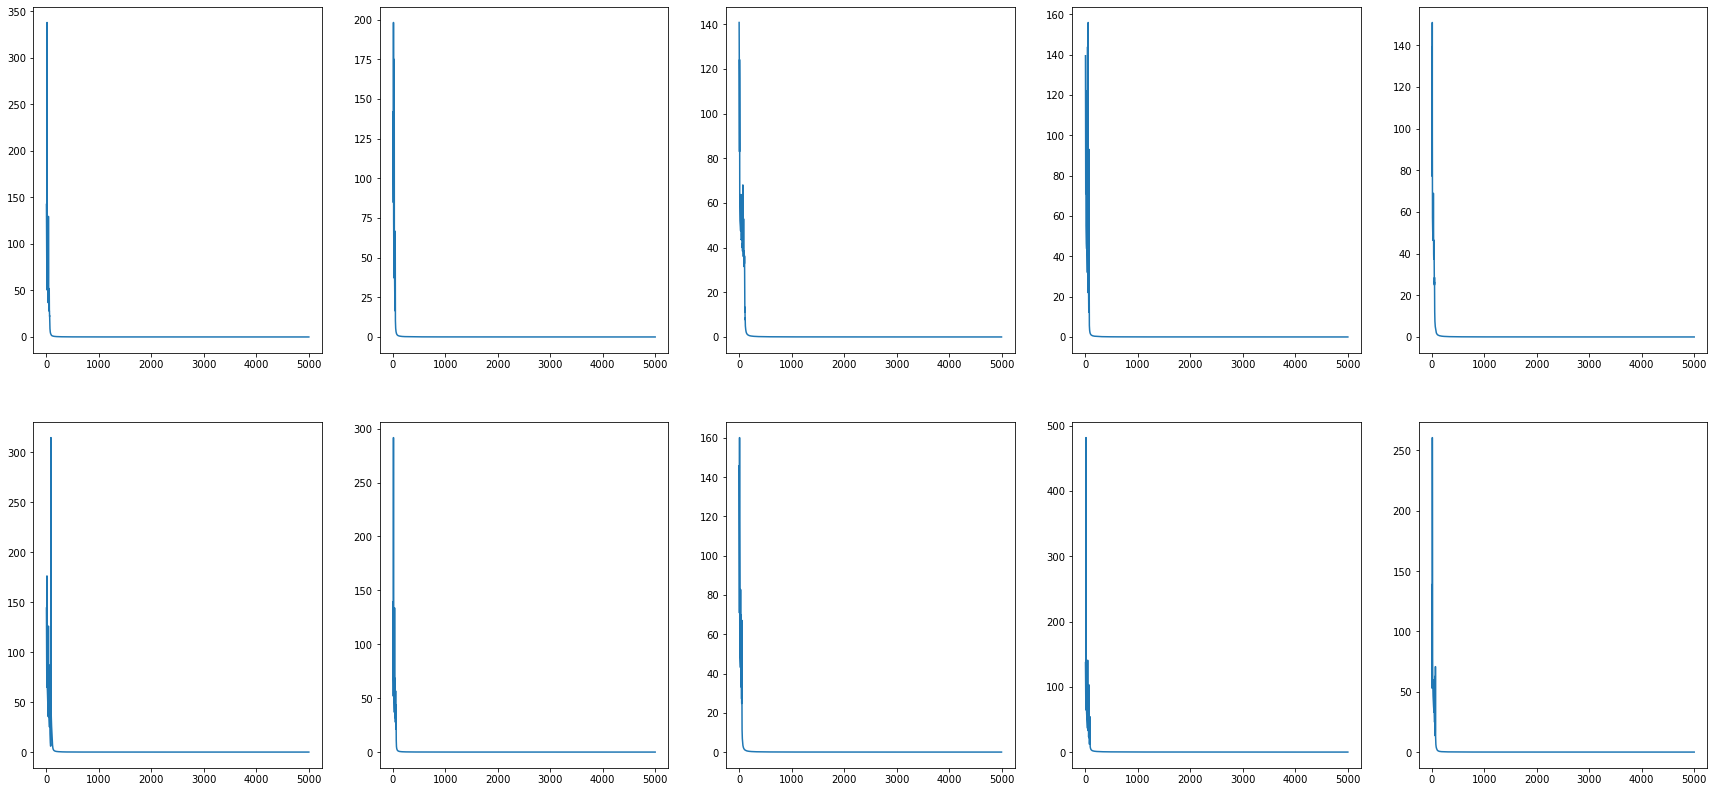

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(30, 14))

for i in range(n_models):

    ax[i//5, i%5].plot(_loss[i])

plt.show()

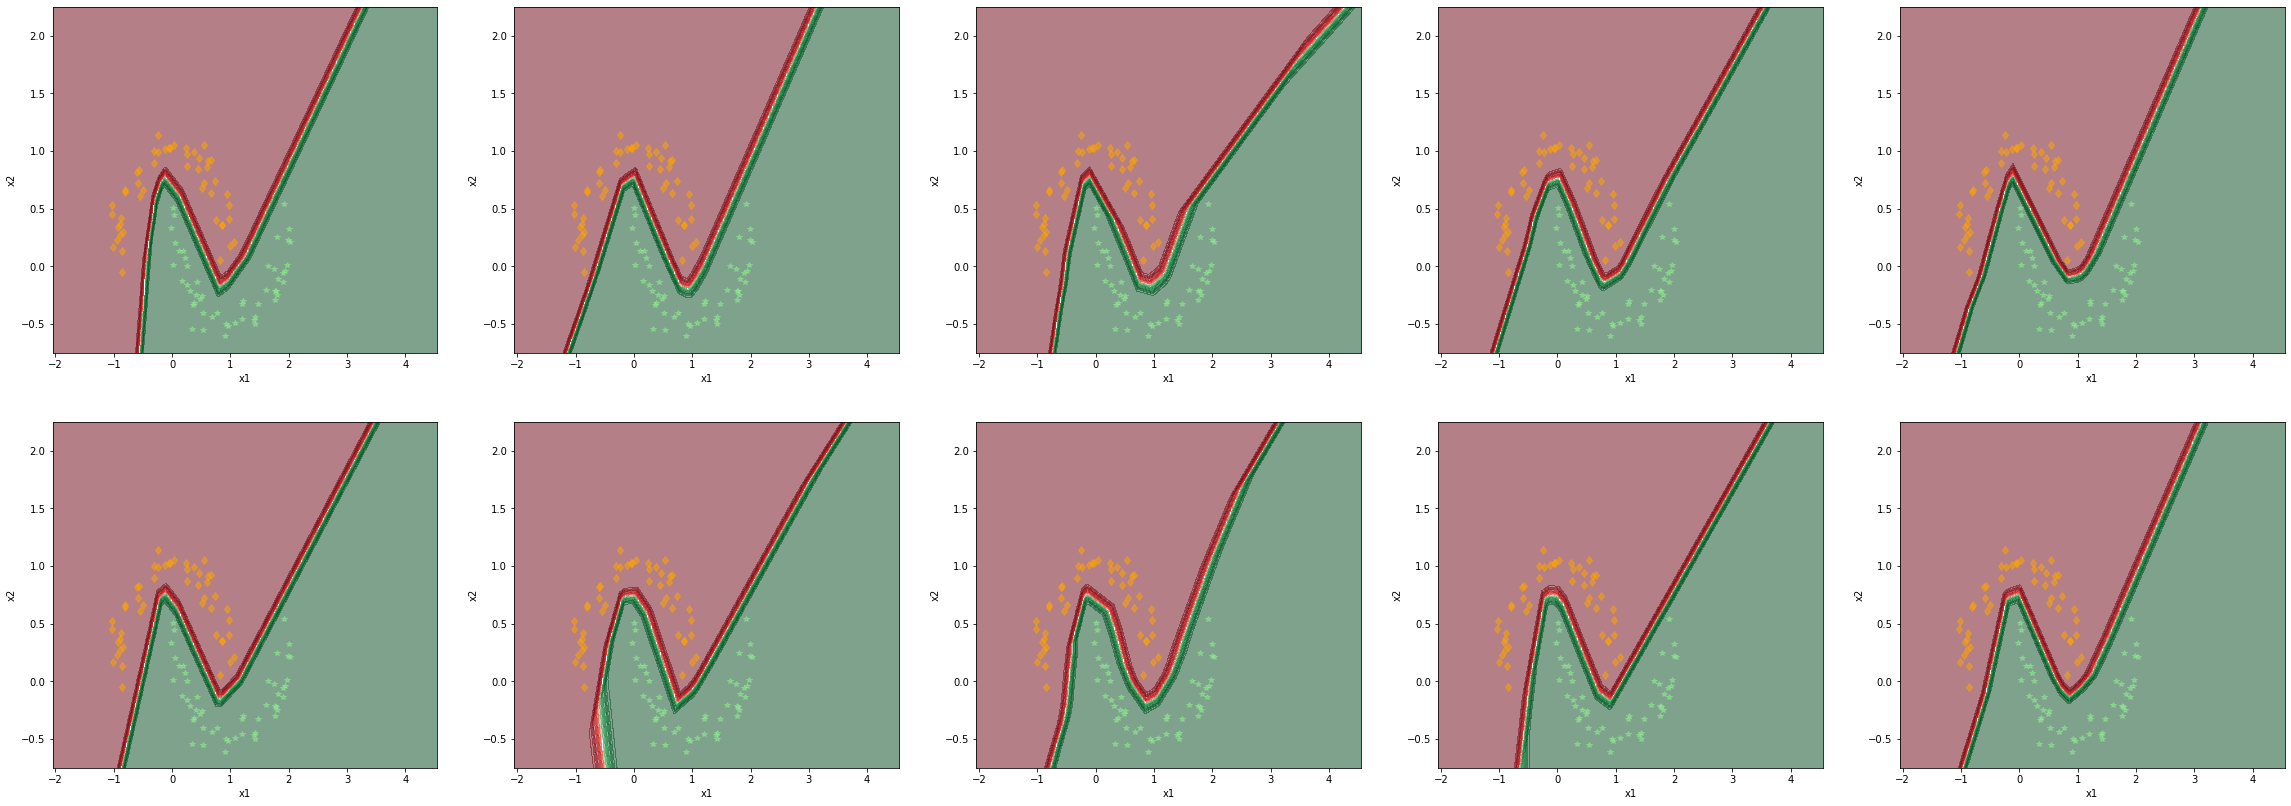

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(40, 14))

for i in range(n_models):
    ax[i//5, i%5] = plot_toy_regions(X_train[:100], y_train[:100],
                          lambda x: predict(x, Wbs[i]),
                          ax=ax[i//5, i%5],
                          xlims=(-1.5, 4),
                          ylims=(-0.5, 2))
plt.show();

In [18]:
def predict_enseble(X, Wbs):
    preds = []
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32, device=Wbs[0].device)
    for Wb in Wbs:
        z = dnn(X, Wb)
        preds.append(torch.sigmoid(z).cpu().detach().numpy())
    
    return sum(preds)/len(preds)

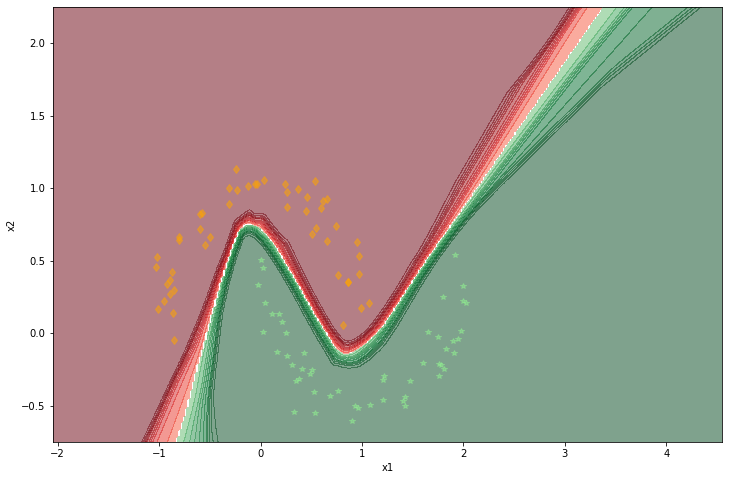

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict_enseble(x, Wbs),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

### Bayesian Model Average

Bayesian Inference allows to make predictions averagins marginalizing over the parameter space of $\theta$ the posterior distribution of $\theta$ having observed some data $\mathcal{D}$:

$$
p(y | x, \mathcal{D}) = \int p(y| x, \theta)p(\theta|\mathcal{D})d\theta
$$

However, $p(\theta|\mathcal{D})$ has no tractable solution for DNNs and we resort to approximate methods instead.

### VI

Approximate the parameters $\phi$ of a variational distribution $q_\phi(\theta)$ such that:
$$
\begin{align}
\phi^* &= \arg\min_\phi D_{KL} [q_\phi(\theta) || p(\theta|\mathcal{D})] \\
&= \arg\min_\phi D_{KL} [ q_\phi(\theta) || \frac{p(\mathcal{D} || \theta)p(\theta)}{p(\mathcal{D})} ] \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}[-\log p(\mathcal{D} || \theta)] + D_{KL} [ q_\phi(\theta) || p(\theta) ]
\end{align}
$$

#### Mean Field Gaussian

Standard Normal prior:

In [48]:
## Initialize variational parameters
mu = dnn.gen_params()
log_var = torch.randn_like(mu) - 5

# Prior distribution
pmu = torch.tensor([0.0], requires_grad=False)
plog_var = torch.tensor([-8.0], requires_grad=False)

In [49]:
def factorized_gauss_KLD(qmu, qlog_var, pmu, plog_var):
    return 0.5 * torch.sum(torch.exp(qlog_var - plog_var)
                           + (qmu - pmu)**2/torch.exp(plog_var) - 1
                           + (plog_var - qlog_var))

In [50]:
def sample_factorized_gauss(mu, log_var, n_samples):
    Z = mu.view(1, -1) + torch.randn((n_samples, mu.shape[0]), device=mu.device)*torch.sqrt(torch.exp(log_var))
    return Z

In [51]:
epochs = 10000
MC_samples = 250

optimizer = torch.optim.Adam([mu, log_var], lr=1e-4)
nll = nn.BCEWithLogitsLoss(reduction='sum')

In [54]:
_elbo = []
_nlls = []
_KL = []

t0 = time.time()
for e in range(epochs):
    
    Wbs = sample_factorized_gauss(mu, log_var, MC_samples)
    
    _nll = 0.0
    
    for Wb in Wbs:
    
        z = dnn(X_train, Wb)
    
        _nll += nll(z, y_train)
        
    _nll /= MC_samples
    
    KL = factorized_gauss_KLD(mu, log_var, pmu, plog_var)
    nelbo = _nll + KL
    
    nelbo.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    _elbo.append(-nelbo.item())
    _nlls.append(_nll.item())
    _KL.append(KL.item())
    
    if e%10==0:
        print("Training: {:.3f}% completed at time {:.2f}s".format(100*(e/epochs), time.time()-t0), end="\r")

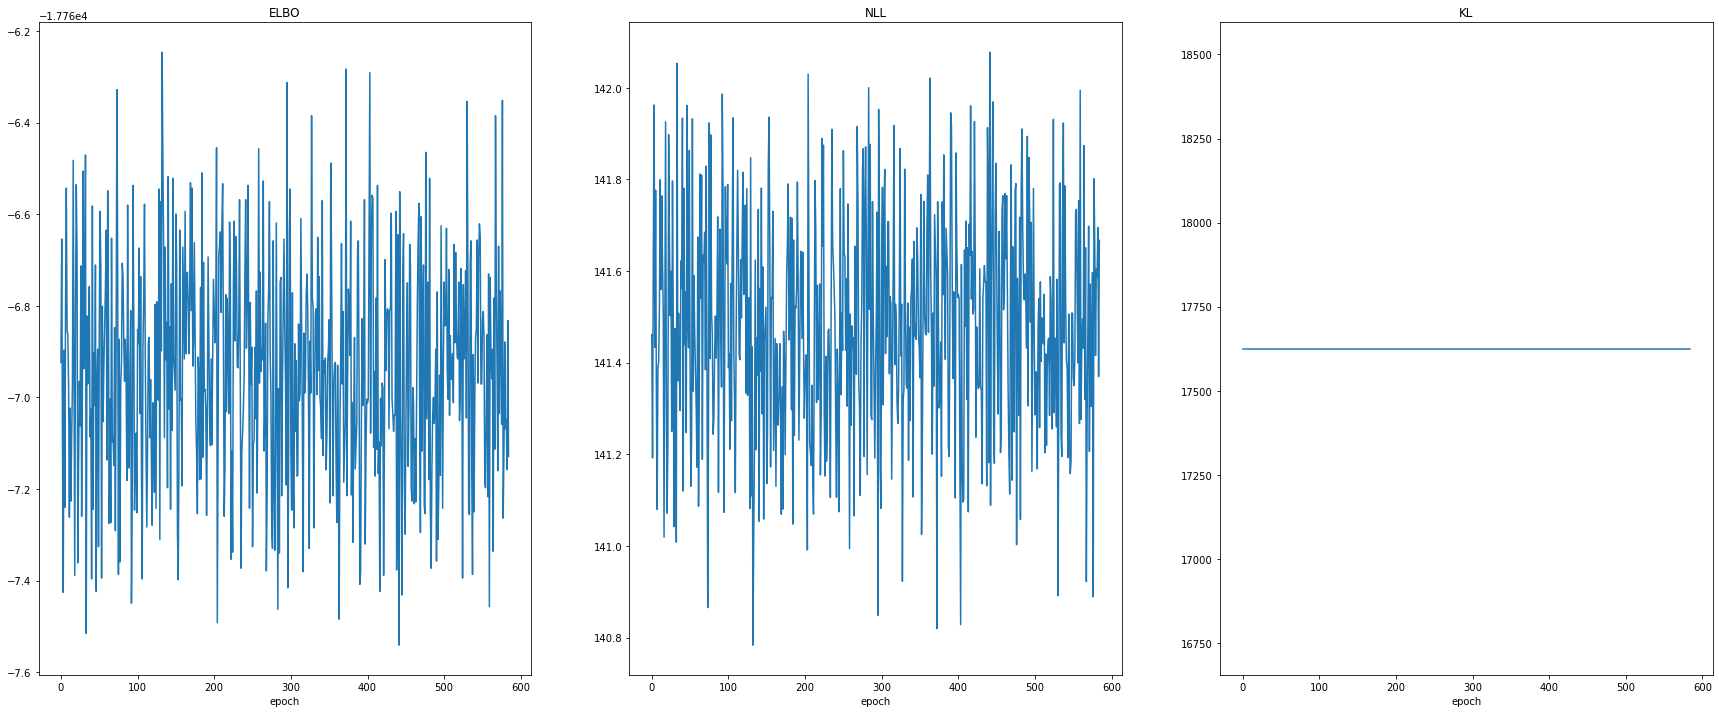

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(30, 12))

ax[0].plot(_elbo)
ax[0].set_title('ELBO')
ax[0].set_xlabel('epoch')

ax[1].plot(_nlls)
ax[1].set_title('NLL')
ax[1].set_xlabel('epoch')

ax[2].plot(_KL)
ax[2].set_title('KL')
ax[2].set_xlabel('epoch')


plt.show()

In [ ]:
Wbs = sample_factorized_gauss(mu, log_var, 100)

fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict_enseble(x, Wbs),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

In [ ]:
Wbs = sample_factorized_gauss(mu, log_var, 10)


fig, ax = plt.subplots(2, 5, figsize=(40, 14))

for i in range(n_models):
    ax[i//5, i%5] = plot_toy_regions(X_train[:100], y_train[:100],
                          lambda x: predict(x, Wbs[i]),
                          ax=ax[i//5, i%5],
                          xlims=(-1.5, 4),
                          ylims=(-0.5, 2))
plt.show();

In [ ]:
mu

In [ ]:
log_var